In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import io
import csv
import gzip
import base64

In [3]:
url = "https://datasets.imdbws.com/"

In [4]:
response = requests.get(url)
soup = BeautifulSoup(response.text,"html.parser")

In [5]:
# Getting names of the zipped files
urlsList = []
for link in soup.find_all('a'):
    urlsList.append(link.get('href'))

nameBasics = urlsList[1]
titleAkas = urlsList[2]
titleBasics = urlsList[3]
titleCrew = urlsList[4]
titleEpisode = urlsList[5]
titlePrincipals = urlsList[6]
titleRatings = urlsList[7]

In [6]:
# Scraping Movie Ratings file
titleRatingsResponse = requests.get(titleRatings)
bytes_io = io.BytesIO(titleRatingsResponse.content)
with gzip.open(bytes_io, 'rt') as read_file:
    df = pd.read_csv(read_file,delimiter='\t')
    df.to_csv('Movie Ratings.csv',index=False)

In [6]:
# Scraping Movie Basics file
titleBasicsResponse = requests.get(titleBasics)
bytes_io_basics = io.BytesIO(titleBasicsResponse.content)
data = pd.read_csv(bytes_io_basics, delimiter="\t", compression='gzip', chunksize=50000, error_bad_lines=False, encoding='utf-8')
with open('Movie Basics.csv', 'a', encoding="utf-8") as f:
    for chunk in data:
        chunk.to_csv(f, index=False)

In [8]:
df_basic = pd.read_csv('Movie Basics.csv')
df_basic.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [10]:
df_rating = pd.read_csv('Movie Ratings.csv')
df_rating.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1698
1,tt0000002,6.1,210
2,tt0000003,6.5,1456
3,tt0000004,6.1,123
4,tt0000005,6.1,2255


# Find the 20 most popular movies with a rank more than 8.0

In [11]:
# Merging Movie basics and Movie Ratings data based on tconst column
df_overall = pd.merge(df_basic,df_rating,on='tconst')

In [12]:
# Converting datatype of startYear column from string to float
converted_startyear = pd.to_numeric(df_overall['startYear'], errors="coerce")
df_overall = df_overall.drop(['startYear'], axis=1)
df_overall['startYear'] = converted_startyear

In [13]:
df_popular = df_overall[df_overall.averageRating > 8.0]
df_popular = df_popular[df_popular.titleType == 'movie']
df_popular.sort_values(by=['numVotes','averageRating'],ascending=False).head(20)

,tconst,titleType,primaryTitle,originalTitle,isAdult,endYear,runtimeMinutes,genres,averageRating,numVotes,startYear
81954,tt0111161,movie,The Shawshank Redemption,The Shawshank Redemption,0,\N,142,Drama,9.3,2383018,1994.0
247477,tt0468569,movie,The Dark Knight,The Dark Knight,0,\N,152,"Action,Crime,Drama",9.0,2346565,2008.0
599836,tt1375666,movie,Inception,Inception,0,\N,148,"Action,Adventure,Sci-Fi",8.8,2104896,2010.0
98333,tt0137523,movie,Fight Club,Fight Club,0,\N,139,Drama,8.8,1885377,1999.0
81737,tt0110912,movie,Pulp Fiction,Pulp Fiction,0,\N,154,"Crime,Drama",8.9,1856167,1994.0
80864,tt0109830,movie,Forrest Gump,Forrest Gump,0,\N,142,"Drama,Romance",8.8,1843649,1994.0
96210,tt0133093,movie,The Matrix,The Matrix,0,\N,136,"Action,Sci-Fi",8.7,1704281,1999.0
89734,tt0120737,movie,The Lord of the Rings: The Fellowship of the Ring,The Lord of the Rings: The Fellowship of the Ring,0,\N,178,"Action,Adventure,Drama",8.8,1687631,2001.0
113265,tt0167260,movie,The Lord of the Rings: The Return of the King,The Lord of the Rings: The Return of the King,0,\N,201,"Action,Adventure,Drama",8.9,1667200,2003.0
45788,tt0068646,movie,The Godfather,The Godfather,0,\N,175,"Crime,Drama",9.2,1651399,1972.0


# Find the 20 best rated movies with over 40,000 votes in the 2000s (year &gt;= 2000)

In [12]:
df_rated = df_overall[df_overall.numVotes > 40000]
df_rated = df_rated[df_rated.titleType == 'movie']
df_rated = df_rated[df_rated.startYear >= 2000]
df_rated.sort_values(by=['numVotes','averageRating'], ascending = False).head(20)

,tconst,titleType,primaryTitle,originalTitle,isAdult,endYear,runtimeMinutes,genres,averageRating,numVotes,startYear
247178,tt0468569,movie,The Dark Knight,The Dark Knight,0,\N,152,"Action,Crime,Drama",9.0,2339441,2008.0
597054,tt1375666,movie,Inception,Inception,0,\N,148,"Action,Adventure,Sci-Fi",8.8,2098237,2010.0
89703,tt0120737,movie,The Lord of the Rings: The Fellowship of the Ring,The Lord of the Rings: The Fellowship of the Ring,0,\N,178,"Action,Adventure,Drama",8.8,1682833,2001.0
113215,tt0167260,movie,The Lord of the Rings: The Return of the King,The Lord of the Rings: The Return of the King,0,\N,201,"Action,Adventure,Drama",8.9,1662834,2003.0
389481,tt0816692,movie,Interstellar,Interstellar,0,\N,169,"Adventure,Drama,Sci-Fi",8.6,1542565,2014.0
587043,tt1345836,movie,The Dark Knight Rises,The Dark Knight Rises,0,\N,164,"Action,Adventure",8.4,1535535,2012.0
113216,tt0167261,movie,The Lord of the Rings: The Two Towers,The Lord of the Rings: The Two Towers,0,\N,179,"Action,Adventure,Drama",8.7,1503672,2002.0
688935,tt1853728,movie,Django Unchained,Django Unchained,0,\N,165,"Drama,Western",8.4,1378864,2012.0
115653,tt0172495,movie,Gladiator,Gladiator,0,\N,155,"Action,Adventure,Drama",8.5,1358010,2000.0
207249,tt0372784,movie,Batman Begins,Batman Begins,0,\N,140,"Action,Adventure",8.2,1324637,2005.0


# Find the average rank of the 10 most popular movies between 2000-2009 (inclusive)

In [14]:
df_average = df_overall[(df_overall.startYear >= 2000) & (df_overall.startYear <= 2009)]
df_average = df_average[df_average.titleType == 'movie']
df_average.sort_values(by=['numVotes','averageRating'],ascending=False).head(10)

,tconst,titleType,primaryTitle,originalTitle,isAdult,endYear,runtimeMinutes,genres,averageRating,numVotes,startYear
247477,tt0468569,movie,The Dark Knight,The Dark Knight,0,\N,152,"Action,Crime,Drama",9.0,2346565,2008.0
89734,tt0120737,movie,The Lord of the Rings: The Fellowship of the Ring,The Lord of the Rings: The Fellowship of the Ring,0,\N,178,"Action,Adventure,Drama",8.8,1687631,2001.0
113265,tt0167260,movie,The Lord of the Rings: The Return of the King,The Lord of the Rings: The Return of the King,0,\N,201,"Action,Adventure,Drama",8.9,1667200,2003.0
113266,tt0167261,movie,The Lord of the Rings: The Two Towers,The Lord of the Rings: The Two Towers,0,\N,179,"Action,Adventure,Drama",8.7,1507647,2002.0
115704,tt0172495,movie,Gladiator,Gladiator,0,\N,155,"Action,Adventure,Drama",8.5,1361662,2000.0
207445,tt0372784,movie,Batman Begins,Batman Begins,0,\N,140,"Action,Adventure",8.2,1328176,2005.0
202358,tt0361748,movie,Inglourious Basterds,Inglourious Basterds,0,\N,153,"Adventure,Drama,War",8.3,1292408,2009.0
253401,tt0482571,movie,The Prestige,The Prestige,0,\N,130,"Drama,Mystery,Sci-Fi",8.5,1210940,2006.0
223088,tt0407887,movie,The Departed,The Departed,0,\N,151,"Crime,Drama,Thriller",8.5,1208884,2006.0
133930,tt0209144,movie,Memento,Memento,0,\N,113,"Mystery,Thriller",8.4,1141384,2000.0


In [21]:
print(df_average.sort_values(by=['numVotes','averageRating'],ascending=False).head(10)["averageRating"].mean())

8.580000000000002


# Find the year in the 1900s when the average rank increased the most, compared to the previous year (Ignore movies with votes &lt; 1000)

In [14]:
df_1900s = df_overall[(df_overall.startYear >= 1900) & (df_overall.startYear < 2000)]
df_1900s = df_1900s[df_1900s.titleType == 'movie']
df_1900s = df_1900s[df_1900s.numVotes >= 1000]

df_average_rank = df_1900s.groupby(['startYear']).mean()
df_average_rank

,averageRating,numVotes
startYear,,
1911.0,7.100000,2428.000000
1913.0,6.920000,1486.600000
1914.0,6.560000,2028.200000
1915.0,6.760000,6389.200000
1916.0,6.950000,7977.000000
...,...,...
1995.0,6.417016,39549.604712
1996.0,6.338442,27735.329146
1997.0,6.408864,36959.711364


In [15]:
df_average_rank['meanDifference'] = df_average_rank['averageRating'] - df_average_rank['averageRating'].shift(1)
df_average_rank

,averageRating,numVotes,meanDifference
startYear,,,
1911.0,7.100000,2428.000000,NaN
1913.0,6.920000,1486.600000,-0.180000
1914.0,6.560000,2028.200000,-0.360000
1915.0,6.760000,6389.200000,0.200000
1916.0,6.950000,7977.000000,0.190000
...,...,...,...
1995.0,6.417016,39549.604712,0.148002
1996.0,6.338442,27735.329146,-0.078573
1997.0,6.408864,36959.711364,0.070421


In [16]:
df_average_rank.sort_values(by='meanDifference',ascending=False).head(1)

,averageRating,numVotes,meanDifference
startYear,,,
1919.0,6.953846,2021.692308,0.278846


# Find the expected average rank for 2013 using linear regression. How good is this regression? (Ignore movies with votes &lt; 1000.)

In [17]:
df_lr = df_overall[df_overall.titleType == 'movie']
df_lr = df_lr[df_lr.numVotes >= 1000]

df_mean = df_lr.groupby(['startYear']).mean()

In [18]:
from sklearn.linear_model import LinearRegression
import numpy as np

In [19]:
LinearModel = LinearRegression()

In [20]:
x = np.array(df_mean['numVotes']).reshape(-1, 1)
y = np.array(df_mean['averageRating']).reshape(-1, 1)

In [21]:
LinearModel.fit(x, y)

LinearRegression()

In [22]:
# Actual average rating in the year 2013
df_mean.iloc[101]

averageRating        6.206081
numVotes         32423.939189
Name: 2013.0, dtype: float64

In [23]:
LinearModel.predict(np.array(df_mean.iloc[101,1]).reshape(-1,1))

array([[6.31619297]])

# Find the correlation between rank and votes for each year in the 1900s. By how much did the correlation coefficient grow each year?

In [24]:
group_object = df_1900s.groupby(by='startYear')
years = group_object.groups.keys()
yearly_correlation = {}
for year in years:
    year_group = group_object.get_group(year)
    yearly_correlation[year] = year_group['averageRating'].corr(year_group['numVotes'])
yearly_correlation = pd.DataFrame(yearly_correlation.items(),columns=['Year','Correlation'])
yearly_correlation.sort_values(by='Year')
yearly_correlation['Diff(Growth)'] = yearly_correlation['Correlation'] - yearly_correlation['Correlation'].shift(1)
yearly_correlation

C:\Users\BASHA\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\BASHA\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Year,Correlation,Diff(Growth)
0,1911.0,NaN,NaN
1,1913.0,-0.540391,NaN
2,1914.0,0.277902,0.818294
3,1915.0,-0.623455,-0.901357
4,1916.0,1.000000,1.623455
...,...,...,...
83,1995.0,0.282840,-0.013602
84,1996.0,0.207503,-0.075337
85,1997.0,0.234292,0.026789
86,1998.0,0.248511,0.014219


# Draw a scatterplot of rank vs votes for every movie with at least 10,000 votes. (x-axis=votes, y-axis=rank)

In [25]:
from matplotlib import pyplot as plt

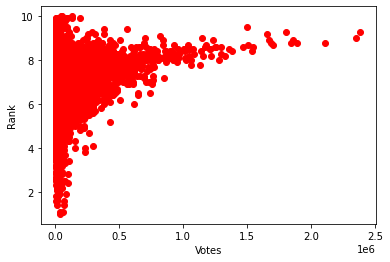

In [26]:
df_numVotes_10000 = df_overall[df_overall.numVotes >= 10000]
plt.scatter(df_numVotes_10000["numVotes"],df_numVotes_10000["averageRating"],color = "r")
plt.xlabel("Votes")
plt.ylabel("Rank")
plt.show()

# Draw bar graph of the number of movies by year since 1900 and Convert it in to html and pdf files

In [28]:
movies_from_1900 = df_overall[df_overall['startYear'] >= 1900]
years = list(set(movies_from_1900['startYear'].tolist()))
count = movies_from_1900.groupby(by='startYear').count().tconst.tolist()

In [29]:
def bar_graph(x, y, img, xlabel, ylabel):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.savefig(img, transparent=True, bbox_inches='tight')
    plt.show()
    img.seek(0)

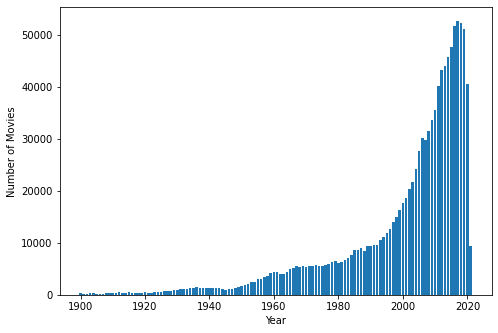

In [30]:
img = io.BytesIO()
bar_graph(years, count, img, "Year", "Number of Movies")
res = base64.b64encode(img.read()).decode("UTF-8")
with open("imdb_graph.html", "w") as file:
    file.write('<div><img src="data:image/png;base64,{}"/></div>'.format(res))

In [31]:
client = pdfcrowd.HtmlToPdfClient('demo', 'ce544b6ea52a5621fb9d55f8b542d14d')
client.convertFileToFile('imdb_graph.html', 'imdb_graph.pdf')